In [1]:
pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install mysql-connector-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='1234567890',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/Govind/Desktop/Ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np


db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "1234567890",
                             database = "ecommerce")

cur = db.cursor()

# List all unique cities where customers are located.

In [7]:
query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [8]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"Total orders placed in 2017 are", data[0][0]

('Total orders placed in 2017 are', 451010)

# Find the total sales per category.

In [9]:
query = """ select upper(products.product_category) category,
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()

data

df = pd.DataFrame(data, columns = ["category", "sales"])
df

,category,sales
0,PERFUMERY,5.067387e+08
1,FURNITURE DECORATION,1.430176e+09
2,TELEPHONY,4.868821e+08
3,BED TABLE BATH,1.712554e+09
4,AUTOMOTIVE,8.522943e+08
...,...,...
69,CDS MUSIC DVDS,1.199430e+06
70,LA CUISINE,2.913530e+06
71,FASHION CHILDREN'S CLOTHING,7.856700e+05
72,PC GAMER,2.174430e+06


# Calculate the percentage of orders that were paid in installments.

In [10]:
query = """ select (sum(case when payment_installments >= 1 then 1
else 0 end))/count(*)*100 from payments
"""

cur.execute(query)

data = cur.fetchall()

'the percentage of orders that were paid in installments is',data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

# Count the number of customers from each state. 

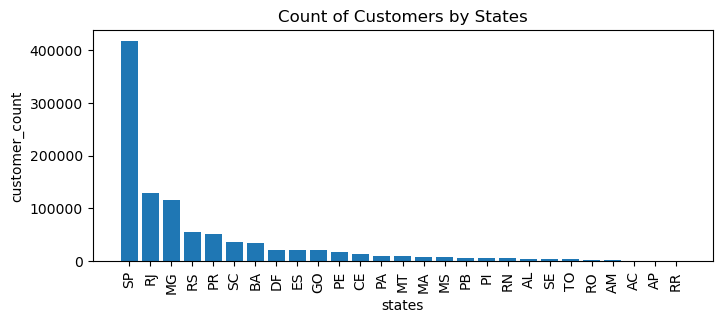

In [11]:
query = """ select customer_state ,count(customer_id)
from customers group by customer_state
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['state', 'customer_count'])
df = df.sort_values(by = 'customer_count', ascending = False)

plt.figure(figsize = (8,3))
plt.bar(df['state'], df['customer_count'])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()

# Calculate the number of orders per month in 2018.

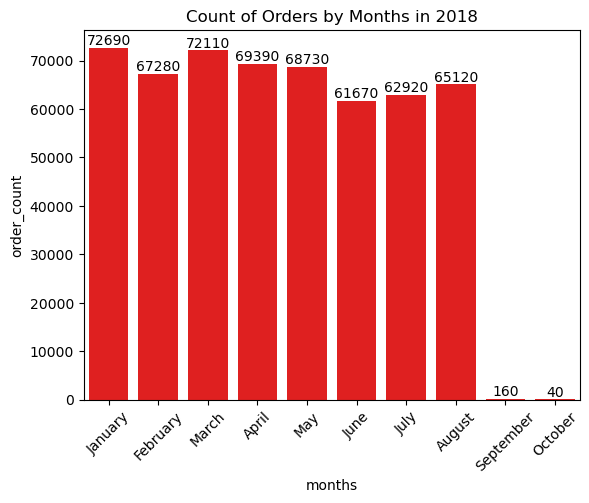

In [12]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['months', 'order_count'])
o = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September' ,'October']

ax = sns.barplot(x = df['months'], y = df['order_count'], data = df, order = o, color = 'red')
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months in 2018")

plt.show()

# Find the average number of products per order, grouped by customer city.

In [13]:
query = """ with count_per_order as
 (select orders.order_id, orders.customer_id, count(order_items.order_id) as order_count
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.order_count),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['customer city', 'average products/order'])
df.head(10)

,customer city,average products/order
0,padre carvalho,700.00
1,celso ramos,650.00
2,datas,600.00
3,candido godoi,600.00
4,matias olimpio,500.00
5,cidelandia,400.00
6,curralinho,400.00
7,picarra,400.00
8,morro de sao paulo,400.00
9,teixeira soares,400.00


# Calculate the percentage of total revenue contributed by each product category.

In [14]:
query = """ select upper(products.product_category) category,
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns = ["category", "percentage distribution"])
df.head()

,category,percentage distribution
0,BED TABLE BATH,1069.75
1,HEALTH BEAUTY,1035.28
2,COMPUTER ACCESSORIES,990.28
3,FURNITURE DECORATION,893.36
4,WATCHES PRESENT,892.77


# Identify the correlation between product price and the number of times a product has been purchased.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np


db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "1234567890",
                             database = "ecommerce")

cur = db.cursor()

query = """ select products.product_category,
count(order_items.product_id),
round (avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category;
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns = ["Category", "order_count", "price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print(("the correlation between price and number of times a product has been purchased is", a[0][1]))

('the correlation between price and number of times a product has been purchased is', -0.10631514167157562)


# Calculate the total revenue generated by each seller, and rank them by revenue.

<function matplotlib.pyplot.show(close=None, block=None)>

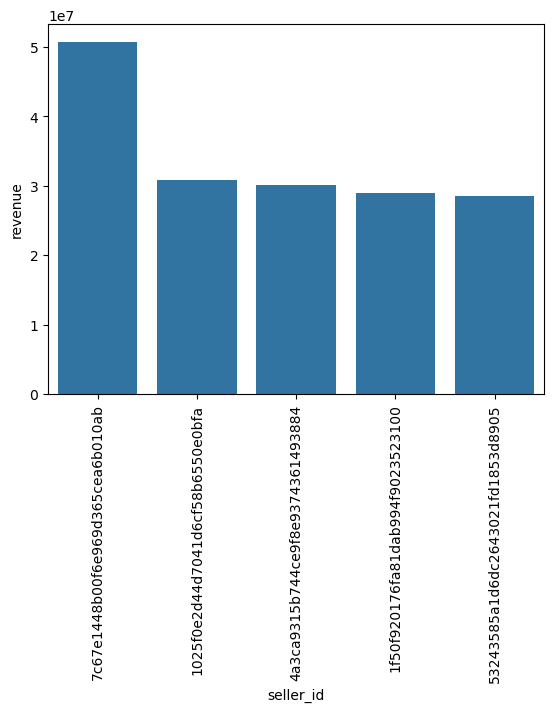

In [16]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value) 
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show

# Calculate the moving average of order values for each customer over their order history.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np


db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "1234567890",
                             database = "ecommerce")

cur = db.cursor()
query = """ select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer_id", "order_purchase_timestamp", "price", "mov avg"])
df = df.head()

# Calculate the cumulative sales per month for each year.

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np


db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "1234567890",
                             database = "ecommerce")

cur = db.cursor()
query = """select years, months, payment, sum(payment)
over(order by years, months) cumulative_sales from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,2.522400e+04,2.522400e+04
1,2016,10,5.909048e+06,5.934272e+06
2,2016,12,1.962000e+03,5.936234e+06
3,2017,1,1.384880e+07,1.978504e+07
4,2017,2,2.919080e+07,4.897584e+07
5,2017,3,4.498636e+07,9.396220e+07
6,2017,4,4.177880e+07,1.357410e+08
7,2017,5,5.929188e+07,1.950329e+08
8,2017,6,5.112764e+07,2.461605e+08
9,2017,7,5.923829e+07,3.053988e+08


# Calculate the year-over-year growth rate of total sales.

In [19]:
query= """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "year_over_year % growth"])
df

,years,year_over_year % growth
0,2016,NaN
1,2017,12112.703758
2,2018,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [20]:
query= """with a as(select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as(select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id)

select 100 * (count(distinct a.customer_id)/ count(distinct b.customer_id))
from a left join b
on a.customer_id = b.customer_id"""

cur.execute(query)
data = cur.fetchall()
data

#since none of our customers are repeated, hence our value is null

[(None,)]

# Identify the top 3 customers who spent the most money in each year.

<Axes: xlabel='id', ylabel='payment'>

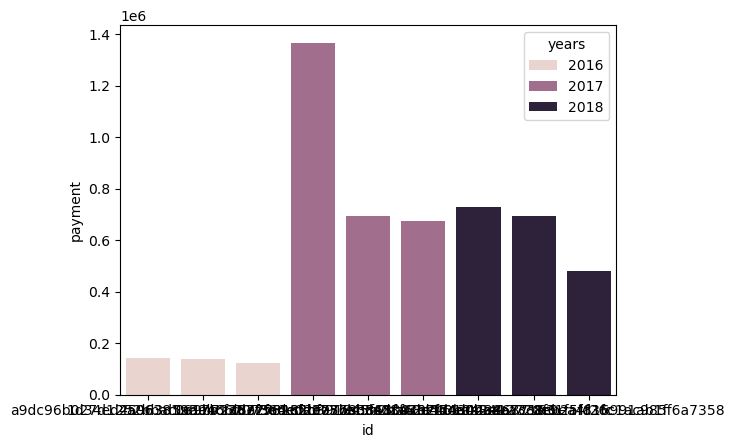

In [21]:
query= """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "id", "payment", "rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 45)
plt.show()